In [1]:
# import packages
import h5py
import numpy as np
import torch
from mirtorch.linear import NuSense, Diff3dgram, NuSenseGram
from mirtorch.alg.cg import CG

# select device
if torch.cuda.is_available():
    print('CUDA is available')
    device0 = torch.device('cuda:2')
else:
    print('CUDA is not available')
    device0 = torch.device('cpu')
    
torch.no_grad()

CUDA is available


In [2]:
# load in the data
fname = '/home/djfrey/data/acr_lps_sos_test/sos_data/data.h5'

with h5py.File(fname, 'r') as h5_file:
    kdata = h5_file['kdata/real'][:] + 1j * h5_file['kdata/imag'][:] # kspace data
    ktraj = h5_file['ktraj'][:] # kspace trajectory (1/cm)
    fov = h5_file['seq_args/fov'][0][0] # fov (cm)
    N = int(h5_file['seq_args/N'][0][0]) # 3D matrix size
    nprj = int(h5_file['seq_args/nprj'][0][0]) # number of projections
    nint = int(h5_file['seq_args/nint'][0][0]) # number of interleaves
ncoil = kdata.shape[0] # number of coils
ndat = kdata.shape[3] # number of samples per projection

In [3]:
# create trajectory (in radians) and data matrix
b = torch.tensor(kdata).reshape(ncoil, 1, nint*nprj*ndat)
om = 2*torch.pi * fov/N * torch.tensor(ktraj.transpose(2,0,1,3)).reshape(3, nint*nprj*ndat)

In [4]:
# loop through coils and calculate AHb
A = NuSense(torch.ones(1,1,N,N,N).to(b.dtype).to(device0), om.to(device0))
AHb = torch.zeros(ncoil,1,N,N,N).to(b.dtype)
for c in range(ncoil):
    bc = b[c:(c+1),:,:].to(device0)
    AHb[c,0] = (A.H * bc).to('cpu').squeeze(0).squeeze(0)

# offload the GPU memory
del A, bc
torch.cuda.empty_cache()

In [5]:
# create the forward model with batch dimension over coils
AHA = NuSenseGram(torch.ones(ncoil,1,N,N,N).to(b.dtype).to(device0), om.to(device0))

# add L2 roughness penalty
lam = 0.01
THT = Diff3dgram(AHA.size_in)
AHA_tikh = AHA + lam*THT

# create the solver
solv = CG(AHA, max_iter=30)

# offload the GPU memory
del AHA, THT, AHA_tikh
torch.cuda.empty_cache()

In [6]:
# solve with CG
x0 = torch.zeros(ncoil,1,N,N,N).to(b.dtype)
x = solv.run(x0.to(device0), AHb.to(device0))

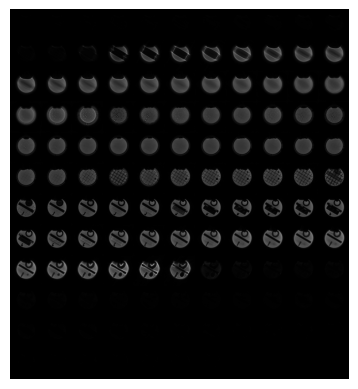

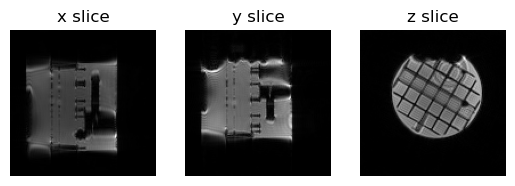

In [ ]:
# visualize the RMS coil combination
from vis3d import im
x_rms = x.abs().pow(2).sum(0).sqrt().cpu().numpy()
im(x_rms[0])
im(x_rms[0],viewtype='mid3')

In [ ]:
# estimate SENSE maps using eSPIRIT